RQ3: Do certain amenities have a more significant impact on success in specific geographic locations?
Compare three geographic locations in Italy: Florence, Venice, Bergamo

In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def load_data(file_path, city_name):
    df = pd.read_excel(file_path)
    df['city'] = city_name
    df = df.copy()  
    return df

def prepare_data_for_analysis(df):
    # filter the dataframe for listings with only 1 bed so the price is more comparable
    onebed_df = df[df['beds'] == 1][['host_location', 'beds', 'amenities', 'price', 'review_scores_rating']].copy()

    valid_df = onebed_df.dropna(subset=['price', 'review_scores_rating'])
    valid_df.loc[:, 'amenities'] = valid_df['amenities'].apply(lambda x: x.strip("[]").replace('"', '').split(", "))


    # one-hot encoding for amenities
    mlb = MultiLabelBinarizer()
    amenities_encoded = mlb.fit_transform(valid_df['amenities'])
    amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_, index=valid_df.index)
    prepared_df = valid_df.join(amenities_df)
    prepared_df.drop('amenities', axis=1, inplace=True) 

    return prepared_df


In [5]:
florence_df = load_data(rf'listings_florence.xlsx', 'Florence')
venice_df = load_data(rf'listings_venice1.xlsx', 'Venice')
bergamo_df = load_data(rf'listings_bergamo.xlsx', 'Bergamo')

all_data = pd.concat([florence_df, venice_df, bergamo_df], ignore_index=True)


florence_prepared_df = prepare_data_for_analysis(florence_df)
#print(florence_prepared_df)
venice_prepared_df = prepare_data_for_analysis(venice_df)
bergamo_prepared_df = prepare_data_for_analysis(bergamo_df)


In [6]:
def analyze_and_visualize(city_df, city_name):

    correlation_matrix = city_df.drop(['host_location', 'beds'], axis=1).corr()
    price_correlation = correlation_matrix['price'].sort_values(ascending=False)
    review_score_correlation = correlation_matrix['review_scores_rating'].sort_values(ascending=False)
    
    top_price_amenities = price_correlation.head(6).index.drop('price')
    top_review_score_amenities = review_score_correlation.head(6).index.drop('review_scores_rating')
    top_amenities = set(top_price_amenities).union(set(top_review_score_amenities))
    top_correlation_matrix = city_df[list(top_amenities) + ['price', 'review_scores_rating']].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmap of Amenities Correlation with Price in {city_name}')
    plt.show()
    
    # identify the top three amenities most correlated with price
    top_features = correlation_matrix['price'].abs().sort_values(ascending=False).index[1:4] 
    #print(top_features)
    # bar charts for these top three amenities showing avg price with and without the amenities
    for feature in top_features:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=feature, y='price', data=city_df)
        plt.title(f'Listing with {feature} in {city_name}')
        plt.ylabel('Price')
        plt.xlabel(feature)
        plt.show()


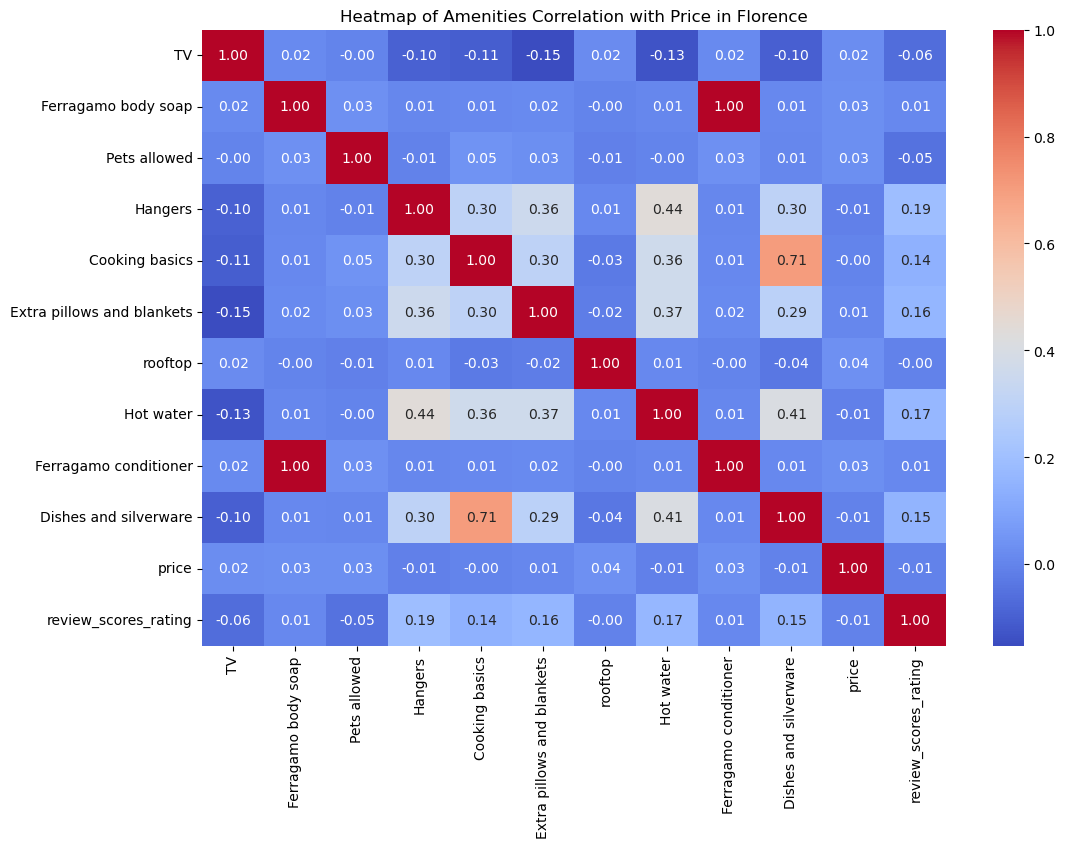

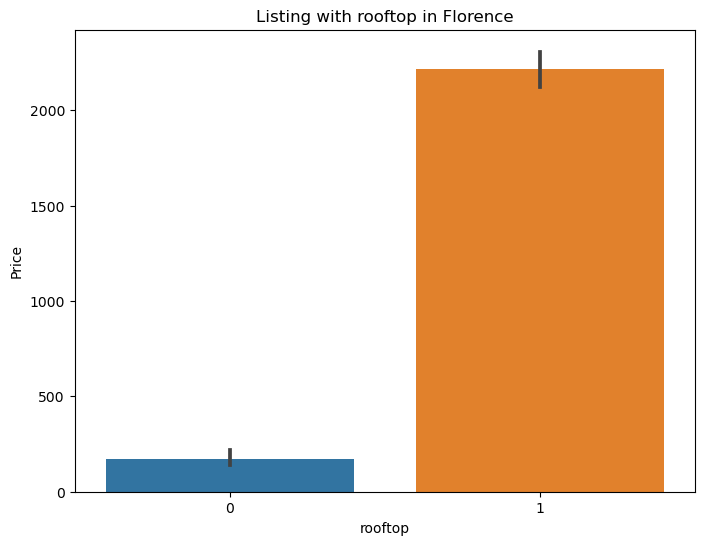

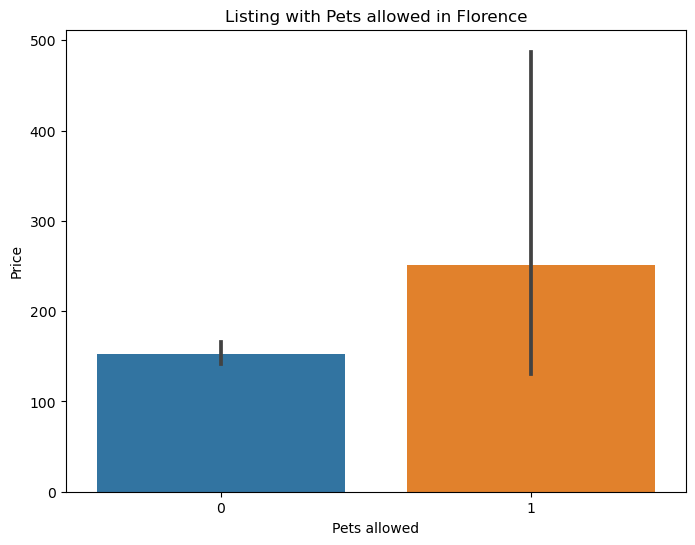

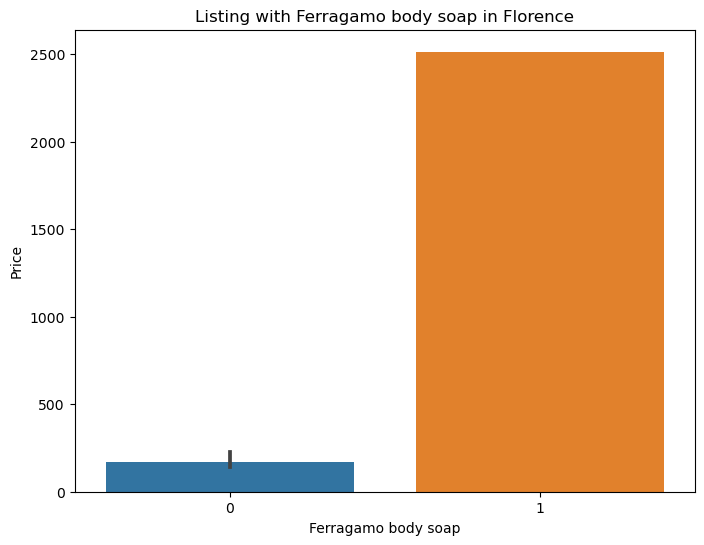

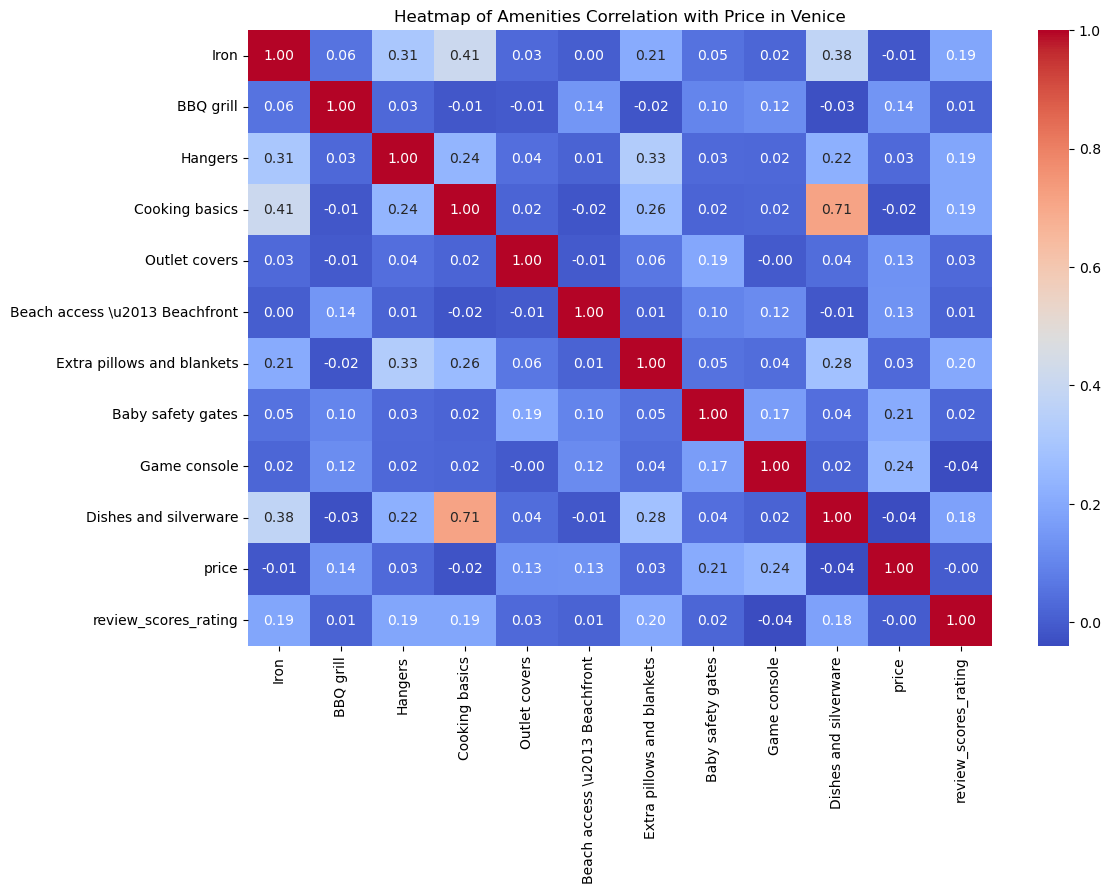

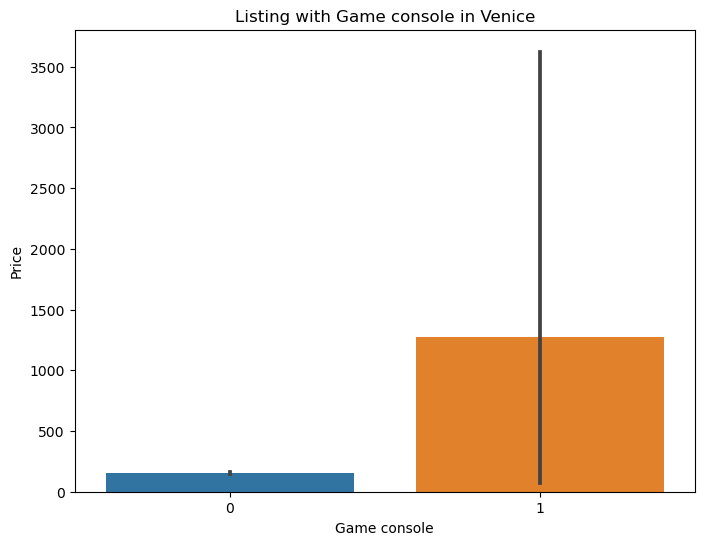

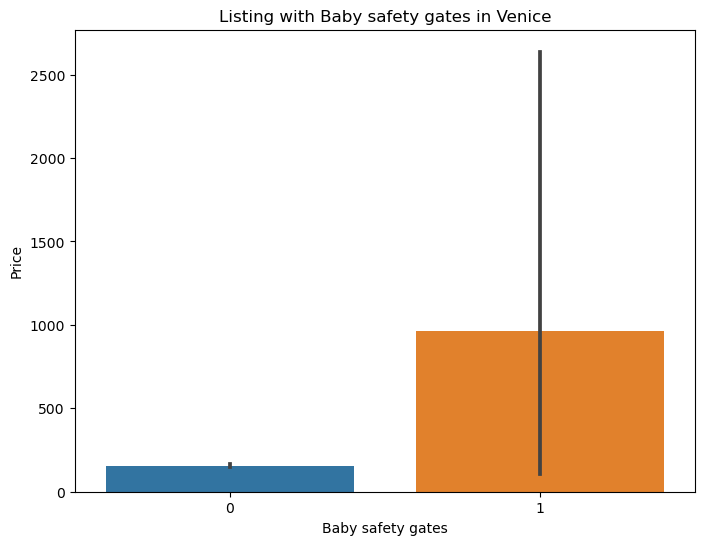

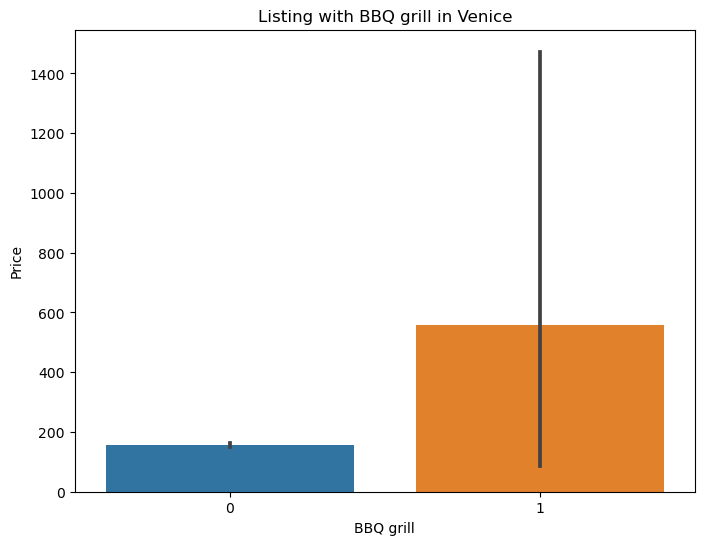

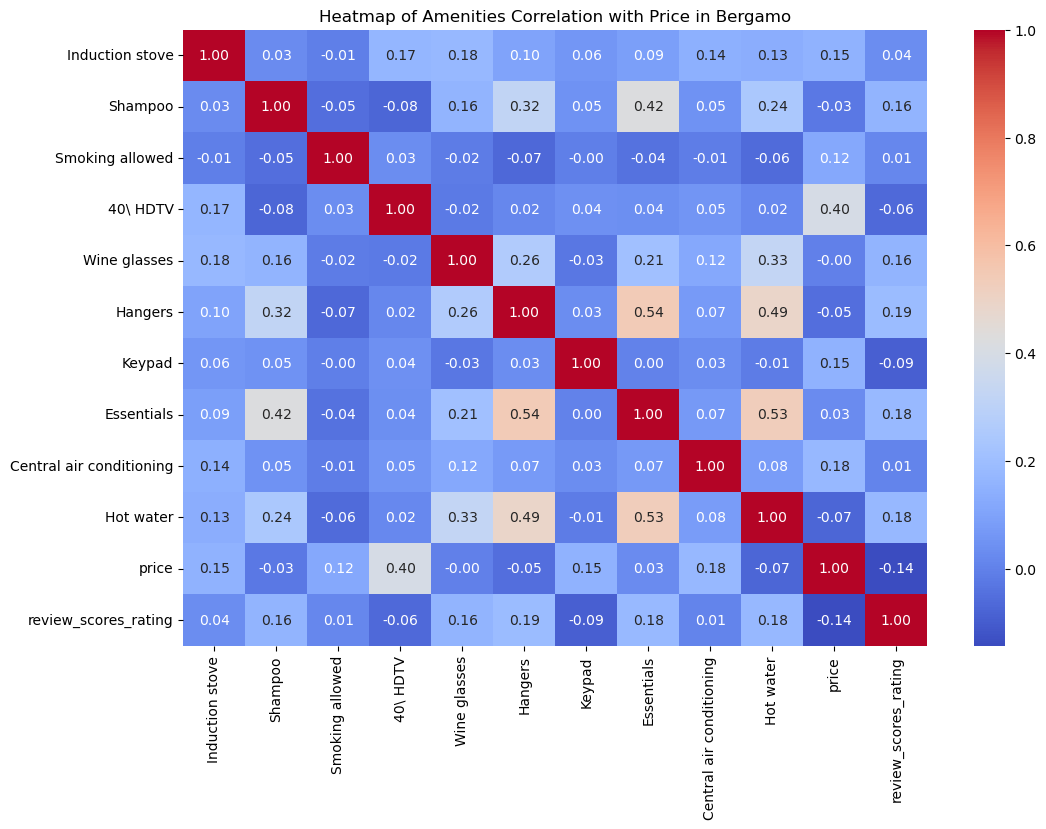

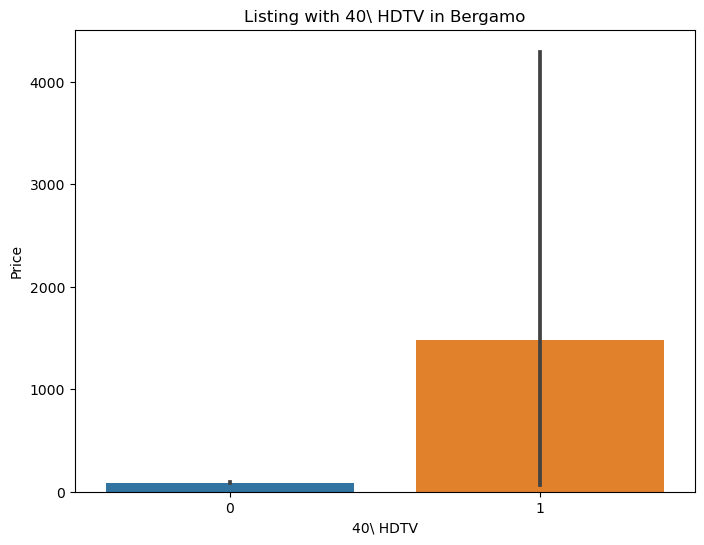

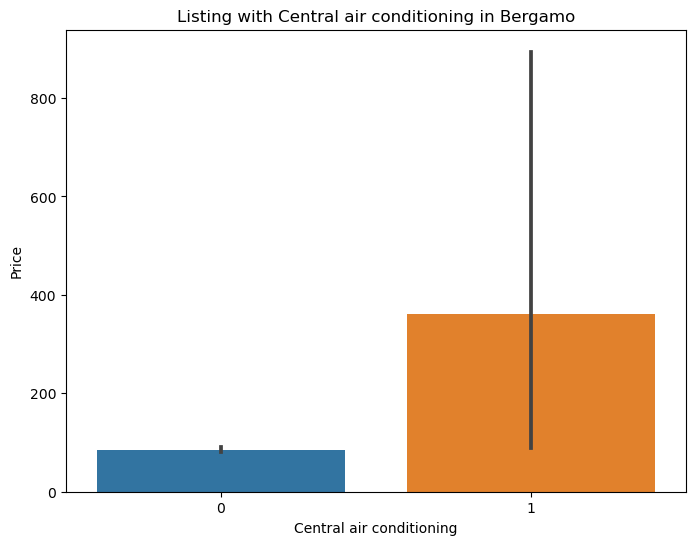

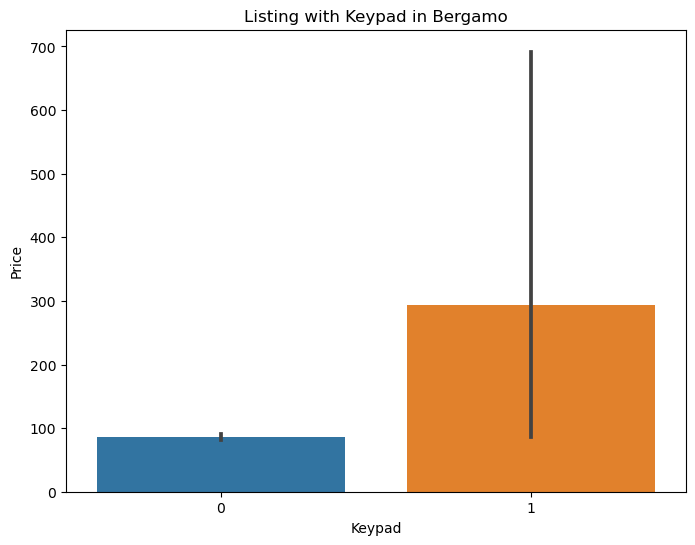

In [7]:
for city_df, city_name in [(florence_prepared_df, 'Florence'), (venice_prepared_df, 'Venice'), (bergamo_prepared_df, 'Bergamo')]:
    analyze_and_visualize(city_df, city_name)